# Dogs vs Cats Image Classification

In this notebook, we'll explore some options to implement a model able to classify images of cats and dogs

In [1]:
import os
import logging
import random as rd
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

2022-03-19 14:39:24.796716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 14:39:24.796740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Basic initialization
rd.seed(9)
tf.random.set_seed(9)

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Constants
CAT_AND_DOGS_DATA_URL: str = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
MOBILE_NET_FEATURE_VECTOR_URL: str = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
SAVED_MODEL_PATH: str = "./model/"
MODEL_CHECKPOINT_PATH: str = "./checkpoints/model_checkpoint.ckpt"
BATCH_SIZE: int = 32
IMAGE_SHAPE: int = 224
EPOCHS: int = 10

## Data loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In [3]:
data_folder_name: str = "cats_and_dogs_filtered"
zip_dir: str = tf.keras.utils.get_file(
    fname=f"{data_folder_name}.zip",
    origin=CAT_AND_DOGS_DATA_URL,
    extract=True # Extract the content from the zip file in the .keras folder
)

data_folder_path: str = f"{os.getcwd()}/{data_folder_name}"
# Check if the data already exists in the current directory
if not os.path.isdir(data_folder_path):
    # Copy the data from the .keras folder to the current folder
    shutil.copytree(src=f"{os.path.dirname(zip_dir)}/{data_folder_name}", dst=f"{os.getcwd()}/{data_folder_name}")

train_dir: str = f"{data_folder_path}/train"
train_dog_dir: str = f"{train_dir}/dogs"
train_cat_dir: str = f"{train_dir}/cats"

validation_dir: str = f"{data_folder_path}/validation"
validation_dog_dir: str = f"{validation_dir}/dogs"
validation_cat_dir: str = f"{validation_dir}/cats"

nb_train_images: int = len(os.listdir(train_dog_dir)) + len(os.listdir(train_cat_dir))
nb_validation_images: int = len(os.listdir(validation_dog_dir)) + len(os.listdir(validation_cat_dir))

print(f"Number of training images for dogs: {len(os.listdir(train_dog_dir))}")
print(f"Number of training images for cats: {len(os.listdir(train_cat_dir))}")
print(f"Number of validation images for dogs: {len(os.listdir(validation_dog_dir))}")
print(f"Number of validation images for cats: {len(os.listdir(validation_cat_dir))}")

Number of training images for dogs: 1000
Number of training images for cats: 1000
Number of validation images for dogs: 250
Number of validation images for cats: 250


The data provided in the dataset only have the train and validation datasets, but not the test one. To solve this, we'll split the validation set to create a test set.

In [4]:
nb_test_dog_images: int = int(len(os.listdir(validation_dog_dir))/2)
nb_test_cat_images: int = int(len(os.listdir(validation_cat_dir))/2)

test_dir: str = f"{os.getcwd()}/{data_folder_name}/test"
test_dog_dir: str = f"{test_dir}/dogs"
test_cat_dir: str = f"{test_dir}/cats"
# Check if the test directory already exists
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

    # Pick random files from the validation set to move to the test set
    os.mkdir(test_dog_dir)
    for i in range(nb_test_dog_images):
        shutil.move(src=f"{validation_dog_dir}/{rd.choice(os.listdir(validation_dog_dir))}", dst=test_dog_dir)
    os.mkdir(test_cat_dir)
    for i in range(nb_test_cat_images):
        shutil.move(src=f"{validation_cat_dir}/{rd.choice(os.listdir(validation_cat_dir))}", dst=test_cat_dir)

print(f"Number of training images for dogs: {len(os.listdir(train_dog_dir))}")
print(f"Number of training images for cats: {len(os.listdir(train_cat_dir))}")
print(f"Number of validation images for dogs: {len(os.listdir(validation_dog_dir))}")
print(f"Number of validation images for cats: {len(os.listdir(validation_cat_dir))}")
print(f"Number of test images for dogs: {len(os.listdir(test_dog_dir))}")
print(f"Number of test images for cats: {len(os.listdir(test_cat_dir))}")

Number of training images for dogs: 1000
Number of training images for cats: 1000
Number of validation images for dogs: 250
Number of validation images for cats: 250
Number of test images for dogs: 250
Number of test images for cats: 250


## Data Preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [5]:
# Create a generator that apply image augmentation to the train images
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode="nearest" # Points outside the boundaries of the input are filled according to the given mode
)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [6]:
# The labels will be 1D binary labels, since we just have two classes (one per directory)
class_mode: str = "binary"

train_data_generator =  train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode=class_mode,
)
validation_data_generator = validation_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode=class_mode,
)
test_data_generator = test_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode=class_mode,
)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Visualize the images

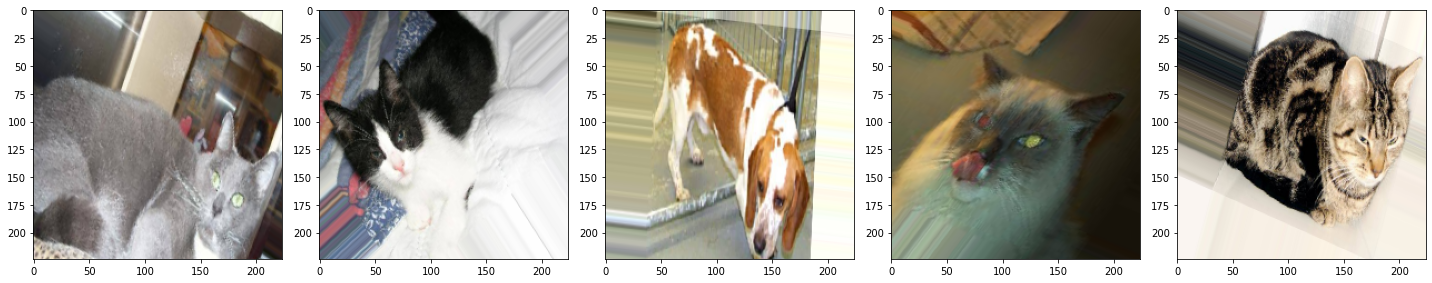

In [7]:
# Get a full batch of images from the train dataset
sample_training_images, _ = next(train_data_generator)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
axes = axes.flatten()
for image, ax in zip(sample_training_images[:5], axes):
    ax.imshow(image)
plt.tight_layout()
plt.show()

## Model creation

The model consists of convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [8]:
model = tf.keras.Sequential(layers=[

    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation="relu",
        # The 3 here stands for the RGB colors that compose the image
        input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
    ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation="relu",
        # The 3 here stands for the RGB colors that compose the image
        input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
    ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation="relu",
        # The 3 here stands for the RGB colors that compose the image
        input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
    ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(), # Tranform the images in arrays
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(
        units=2, # We are classifing two classes
        activation="softmax"
    ),
])

2022-03-19 14:39:30.327239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-19 14:39:30.327263: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-19 14:39:30.327280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lenovo): /proc/driver/nvidia/version does not exist
2022-03-19 14:39:30.327820: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False # Set to False since the last layer already applies the softmax
    ),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [10]:
history = model.fit(
    x=train_data_generator,
    validation_data=validation_data_generator,
    epochs=EPOCHS,
    steps_per_epoch=int(nb_train_images/float(BATCH_SIZE)),
    validation_steps=int(nb_validation_images/float(BATCH_SIZE)),
    # To avoid overfitting, we'll stop when no improvement is made in the validation set
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10, # Number of epochs with no improvement after which training will be stopped.
    )]
)

Epoch 1/10
62/62 [==============================] - 107s 2s/step - loss: 0.8191 - accuracy: 0.5076 - val_loss: 0.6936 - val_accuracy: 0.5083
Epoch 2/10
62/62 [==============================] - 98s 2s/step - loss: 0.6937 - accuracy: 0.5005 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/10
62/62 [==============================] - 100s 2s/step - loss: 0.6925 - accuracy: 0.5051 - val_loss: 0.6867 - val_accuracy: 0.5021
Epoch 4/10
62/62 [==============================] - 99s 2s/step - loss: 0.6920 - accuracy: 0.5091 - val_loss: 0.6922 - val_accuracy: 0.5021
Epoch 5/10
62/62 [==============================] - 114s 2s/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6927 - val_accuracy: 0.5021
Epoch 6/10
62/62 [==============================] - 101s 2s/step - loss: 0.6935 - accuracy: 0.5066 - val_loss: 0.6926 - val_accuracy: 0.5583
Epoch 7/10
62/62 [==============================] - 101s 2s/step - loss: 0.6918 - accuracy: 0.5264 - val_loss: 0.6938 - val_accuracy: 0.5021
Epoch 8/10
62/6

### Results

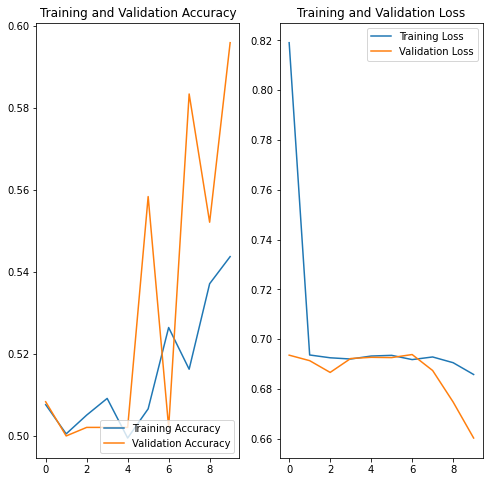

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
test_loss, test_accuracy = model.evaluate(
    x=test_data_generator,
    batch_size=BATCH_SIZE,
)
print(f"Model performace on test set\nAccuracy: {100*test_accuracy}%\nLoss: {test_loss}")

16/16 [==============================] - 6s 350ms/step - loss: 0.6628 - accuracy: 0.5960
Model performace on test set
Accuracy: 59.60000157356262%
Loss: 0.6627979278564453


## A better approach: Transfer Learning

### TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

You can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

Here, the model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [13]:
feature_extractor = hub.KerasLayer(
    MOBILE_NET_FEATURE_VECTOR_URL,
    # MobileNet is expecting images of 224 × 224 pixels, in 3 color channels (RGB).
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
)
# Freeze the variables in the feature extractor layer,
# so that the training only modifies the final classifier layer.
feature_extractor.trainable = False

mobile_net_model = tf.keras.Sequential([
  feature_extractor,
  # Attach a classification head
  tf.keras.layers.Dense(units=2, activation="softmax")
])

mobile_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
mobile_net_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
mobile_net_history = mobile_net_model.fit(
    x=train_data_generator,
    validation_data=validation_data_generator,
    epochs=EPOCHS,
    steps_per_epoch=int(nb_train_images/float(BATCH_SIZE)),
    validation_steps=int(nb_validation_images/float(BATCH_SIZE)),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5, # Number of epochs with no improvement after which training will be stopped.
        ),
        # Save the model weights after each epoch 
        tf.keras.callbacks.ModelCheckpoint(
            filepath=MODEL_CHECKPOINT_PATH,
            save_weights_only=True,
        )
    ]
)

Epoch 1/10
62/62 [==============================] - 44s 684ms/step - loss: 0.2522 - accuracy: 0.8948 - val_loss: 0.0640 - val_accuracy: 0.9792
Epoch 2/10
62/62 [==============================] - 45s 730ms/step - loss: 0.1324 - accuracy: 0.9482 - val_loss: 0.0406 - val_accuracy: 0.9896
Epoch 3/10
62/62 [==============================] - 46s 740ms/step - loss: 0.1231 - accuracy: 0.9472 - val_loss: 0.0360 - val_accuracy: 0.9937
Epoch 4/10
62/62 [==============================] - 47s 746ms/step - loss: 0.1220 - accuracy: 0.9548 - val_loss: 0.0341 - val_accuracy: 0.9917
Epoch 5/10
62/62 [==============================] - 47s 745ms/step - loss: 0.1328 - accuracy: 0.9487 - val_loss: 0.0340 - val_accuracy: 0.9917
Epoch 6/10
62/62 [==============================] - 44s 707ms/step - loss: 0.1316 - accuracy: 0.9466 - val_loss: 0.0357 - val_accuracy: 0.9875
Epoch 7/10
62/62 [==============================] - 45s 721ms/step - loss: 0.1115 - accuracy: 0.9538 - val_loss: 0.0311 - val_accuracy: 0.9917

In [23]:
# Save the complete model
mobile_net_model.save(SAVED_MODEL_PATH)

### Results

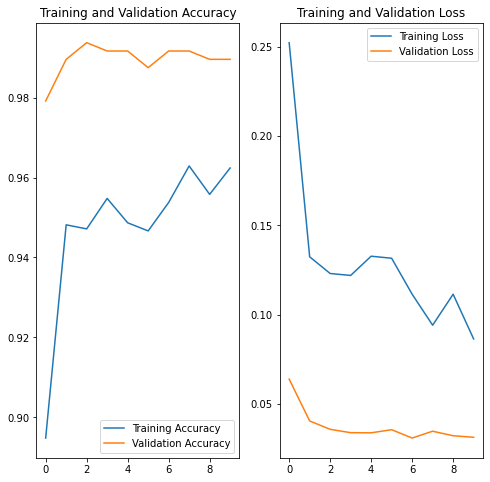

In [16]:
acc = mobile_net_history.history['accuracy']
val_acc = mobile_net_history.history['val_accuracy']

loss = mobile_net_history.history['loss']
val_loss = mobile_net_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

In [17]:
test_loss, test_accuracy = mobile_net_model.evaluate(
    x=test_data_generator,
    batch_size=BATCH_SIZE,
)
print(f"Mobile Net model performace on test set\nAccuracy: {100*test_accuracy:.2f}%\nLoss: {test_loss}")

16/16 [==============================] - 8s 458ms/step - loss: 0.0517 - accuracy: 0.9800
Mobile Net model performace on test set
Accuracy: 98.00%
Loss: 0.0517103336751461


### Check the predictions

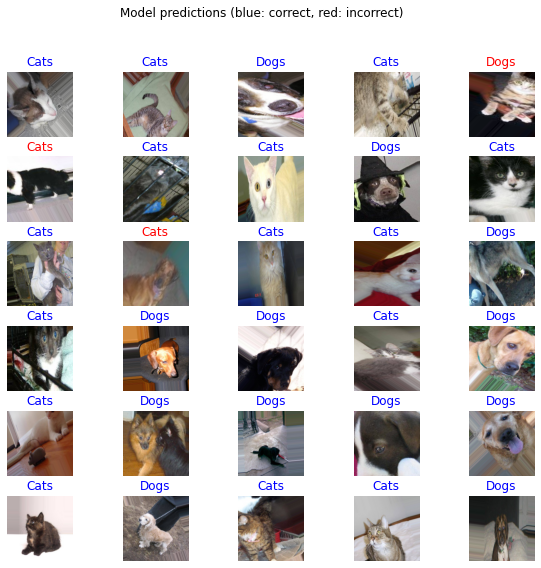

In [21]:
# Get a full batch of images from the train dataset
class_names = np.array(list(train_data_generator.class_indices.keys()))
sample_batch_data, sample_batch_labels  = next(train_data_generator)
predicted_batch = mobile_net_model.predict(sample_batch_data)
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(sample_batch_data[n])
  color = "blue" if predicted_ids[n] == sample_batch_labels[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")